# Big Data Analytics Homework 03

*Complete this assignment in Google Colab. Prior to submitting a copy of this notebook (.ipynb format), run every cell and ensure you have corrected all runtime errors. Be sure to fill in your Name and SUID in the following cell. As always, you must do your own work. This means you may not use answers to the following questions generated by any other person or a generative AI tool such as ChatGPT. You may, however, discuss this assignment with others in a general way and seek help when you need it, but, again, you must do your own work.*

Name: Gughapriyaa Elango

SUID: 585992381

## Medical Insurance Analysis
This assignment uses a medical insurance dataset with the following columns:
- **age**: Age of primary beneficiary
- **sex**: Female/Male
- **bmi**: Body mass index, providing an understanding of body weight relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- **children**: Number of children covered by health insurance / Number of dependents
- **smoker**: Is a smoker — yes/no
- **region**: The beneficiary's residential area in the US — northeast, southeast, southwest, northwest.
- **charges**: Individual medical costs billed by health insurance

## Setup

In [1]:
! pip install pyspark -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# download the insurance data set
%%bash
if [[ ! -f insurance.csv ]]; then
 wget https://syr-bda.s3.us-east-2.amazonaws.com/insurance.csv -q
fi

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Homework 03')\
    .getOrCreate()

## Data Exploration

### Q1

Read the data into a Spark DataFrame named `insurance`. Column names should be age, sex, bmi, children, smoker, region, and charges. Print the resulting DataFrame schema and shape (number of rows, number of columns). Verify your schema makes sense. If the schema does not makes sense, fix it.

In [6]:
# your code here
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("sex", StringType(), True),
    StructField("bmi", DoubleType(), True),
    StructField("children", IntegerType(), True),
    StructField("smoker", StringType(), True),
    StructField("region", StringType(), True),
    StructField("charges", DoubleType(), True)
])

insurance = spark.read.csv("insurance.csv", header=True, schema=schema)

insurance.printSchema()
print("Number of rows:", insurance.count())
print("Number of columns:", len(insurance.columns))


root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)

Number of rows: 1338
Number of columns: 7


In [12]:
insurance.show(5)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows



### Q2

The features of this data set are `age`, `sex`, `bmi`, `children`, `smoker`, and `region`. The target variable is `charges`. For each numeric feature, calculate its correlation with the target variable.

Describe which variables are positively correlelated, which are negatively correlated, if the relationship is weak or strong, and if these observations align with your expectations. Be detailed in your explanation.

In [7]:
# your code here
from pyspark.sql.functions import corr
age_correlation = insurance.select(corr("age", "charges")).collect()[0][0]
bmi_correlation = insurance.select(corr("bmi", "charges")).collect()[0][0]
children_correlation = insurance.select(corr("children", "charges")).collect()[0][0]
print("Correlation between age and charges:", age_correlation)
print("Correlation between bmi and charges:", bmi_correlation)
print("Correlation between children and charges:", children_correlation)

Correlation between age and charges: 0.299008193330648
Correlation between bmi and charges: 0.19834096883362903
Correlation between children and charges: 0.06799822684790492


Age and Charges:

Between age and charges, there is a mild positive correlation, it is weak.
The correlation between age and charges is expected to be positive, as older individuals tend to have higher medical charges due to age-related health issues. The correlation should be relatively strong.

BMI and Charges:

The relationship between BMI and charges is not be as strong as age, as BMI is just one factor influencing medical charges. There is a weak positive correlation. However,I expected it to be positive since higher BMI often leads to more health-related issues and, therefore, higher medical charges.

Children and Charges:

The correlation between the number of children and charges is weaker compared to age and BMI. Having more children might increase healthcare costs, but other factors also play a role. The relationship is is neutral.

### Q3

Create two plots which highlight something interesting/surprising about this data set. Provide detailed written descriptions of each and describe what is interesting or suprising about them.

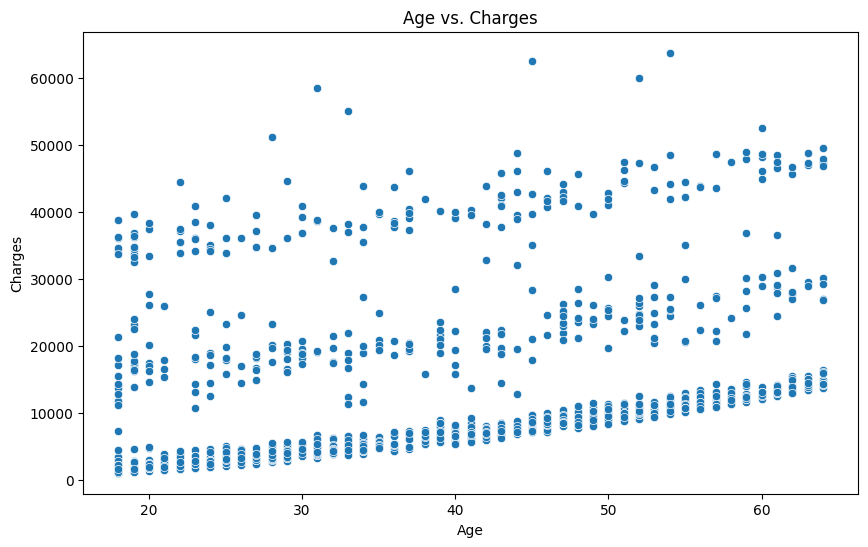

In [8]:
# your code for plot 1 here
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x="age", y="charges", data=insurance.toPandas())
plt.title("Age vs. Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

This scatter plot shows the relationship between age and insurance charges. What's interesting about this plot is the variability in charges for different age groups. While it's expected that charges increase with age, this plot reveals some unexpected findings, such as high charges for specific age groups or outliers. These variations are unexplainable and surprising, to see the huge amount of medical insurance for younger ages in 20s and 30s. There are certainly outliers in the data with regards to age.

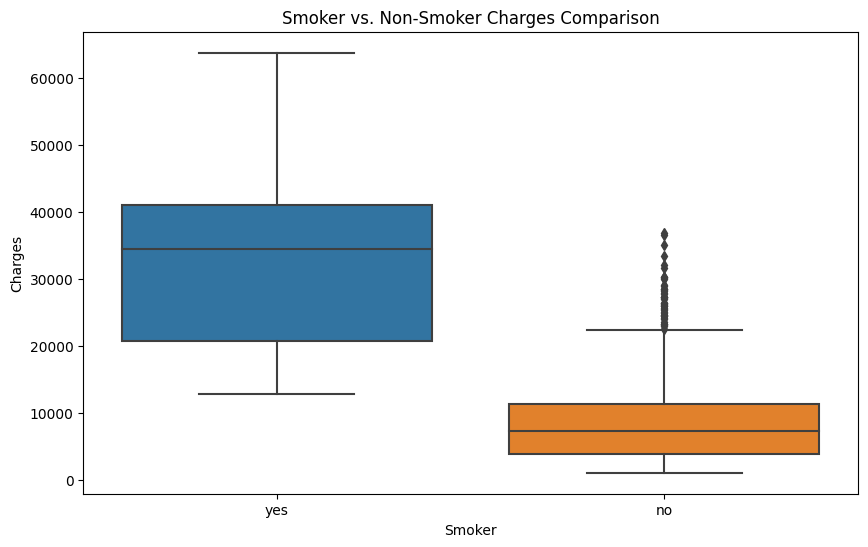

In [9]:
# your code for plot 2 here
plt.figure(figsize=(10, 6))
sns.boxplot(x="smoker", y="charges", data=insurance.toPandas())
plt.title("Smoker vs. Non-Smoker Charges Comparison")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()

This box plot compares insurance charges for smokers and non-smokers. We can observe that smokers have higher insurance charges due to the increased health risks associated with smoking. However, the extent of the difference might be surprising. This plot highlights the stark contrast in charges between these two groups, emphasizing the financial implications of smoking on healthcare costs.

## Predict Insurance Charges with Linear Regression

### Q4

In this step you will perform feature engineering. The `insurance` data set is not yet ready for linear regression because some columns are categorical.

Create a new dataframe called `insurance_fe` which adds new feature engineered columns. Refer to previous labs on best practices to prepare your data for linear regression.

Encapsulate your feature engineering steps in a pipeline called `fe_pipe`. Explain each step you take and your reasons for doing so.

In [22]:
# your code here
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("InsuranceFeatureEngineering").getOrCreate()

sex_indexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")
sex_encoder = OneHotEncoder(inputCols=["sex_indexed"], outputCols=["sex_encoded"])

smoker_indexer = StringIndexer(inputCol="smoker", outputCol="smoker_indexed")
smoker_encoder = OneHotEncoder(inputCols=["smoker_indexed"], outputCols=["smoker_encoded"])

region_indexer = StringIndexer(inputCol="region", outputCol="region_indexed")
region_encoder = OneHotEncoder(inputCols=["region_indexed"], outputCols=["region_encoded"])


feature_columns = ["age", "bmi", "children", "sex_encoded", "smoker_encoded","region_indexed","region_encoded"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
fe_stages = [
    sex_indexer, sex_encoder,
    smoker_indexer, smoker_encoder,
    region_indexer, region_encoder,
    assembler
]
fe_pipe = Pipeline(stages=fe_stages)
insurance_fe = fe_pipe.fit(insurance).transform(insurance)

The columns which have binary values are encoded. label encoding is used to transform categorical variables into numerical representations for further processing in a machine learning pipeline. Label encoding assigns a unique integer to each category in a categorical column, essentially converting the categories into numerical labels.
VectorAssembler is used to assemble the selected features into a single vector column

In [15]:
# do not modify
display(insurance_fe.show(10))

+---+------+------+--------+------+---------+-----------+-----------+-------------+--------------+--------------+--------------+--------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_indexed|  sex_encoded|smoker_indexed|smoker_encoded|region_indexed|region_encoded|            features|
+---+------+------+--------+------+---------+-----------+-----------+-------------+--------------+--------------+--------------+--------------+--------------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|        1.0|    (1,[],[])|           1.0|     (1,[],[])|           2.0| (3,[2],[1.0])|(9,[0,1,5,8],[19....|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|        0.0|(1,[0],[1.0])|           0.0| (1,[0],[1.0])|           0.0| (3,[0],[1.0])|[18.0,33.77,1.0,1...|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|        0.0|(1,[0],[1.0])|           0.0| (1,[0],[1.0])|           0.0| (3,[0],[1.0])|[28.0,33.0,3.0,1....|
| 33|  mal

None

### Q5

Create a new pipeline named `lr_pipe` which encapsulates `fe_pipe`, any needed linear regression support objects, and a linear regression object.  Linear regression support objects are anything you need over and above what is in `fe_pipe` in order to successfully run linear regression.

Train and test `lr_pipe` using `insurance_fe` (remember to split your data into train and test sets). To evaluate `lr_pipe`, use a built-in Spark evaluator object to compute MSE. Save the result in `lr_test_mse`.

In [25]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="charges")
lr_pipe = Pipeline(stages=[fe_pipe, lr])
train_data, test_data = insurance.randomSplit([0.7, 0.3], seed=50)
lr_model = lr_pipe.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="charges", metricName="mse")
lr_test_mse = evaluator.evaluate(predictions)

In [24]:
# do not modify
print(f'Linear regression test MSE: {lr_test_mse:.0f}')

Linear regression test MSE: 29647598


### Q6

Next, we want to perform inference using our linear regression model.

In the following cell, modify the pipeline above by adding a `StandardScaler` stage. Name this pipeline `lr_pipe_inf` (inf stands for inference).

For this model, only use features that were originally numeric.

Fit the model on the test data and print the MSE as you did above. Does this model perform better than the previous model?

In [31]:
# your code here
feature_columns = ["age", "bmi", "children"]
numeric_assembler = VectorAssembler(inputCols=["age", "bmi", "children"], outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features", withStd=True, withMean=True)

lr_inf = LinearRegression(featuresCol="scaled_features", labelCol="charges")
lr_pipe_inf = Pipeline(stages=[numeric_assembler, scaler, fe_pipe, lr_inf])

lr_model_inf = lr_pipe_inf.fit(train_data)
predictions_inf = lr_model_inf.transform(test_data)

evaluator_inf = RegressionEvaluator(predictionCol="prediction", labelCol="charges", metricName="mse")
lr_test_mse_inf = evaluator_inf.evaluate(predictions_inf)
print(f'Linear regression test MSE (with StandardScaler): {lr_test_mse_inf:.0f}')


Linear regression test MSE (with StandardScaler): 118402942


Our Mean Standard Error is 118402942, which is higher in this model comparing to the first model, which is better.

## Classification of High/Low Charges with Logistic Regression

### Q7

Next we will modify our target variable for classification.

Create a new dataframe named `insurance_stratefied` by adding a new column to `insurance_fe` named `rate_pool`.

Create the `rate_pool` column by stratifying the `charges` column into charges greater than and less than the median of the `charges` column. Assign an integer 0 to charges that are less than or equal to the median, and a 1 to charges greater than the median.

In [32]:
# your code here
from pyspark.sql.functions import lit, when
median_charges = insurance_fe.approxQuantile("charges", [0.5], 0.01)[0]
insurance_stratified = insurance_fe.withColumn("rate_pool", when(insurance_fe["charges"] > median_charges, lit(1)).otherwise(lit(0)))
insurance_stratified.show()




+---+------+------+--------+------+---------+-----------+-----------+-------------+--------------+--------------+--------------+--------------+--------------------+---------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_indexed|  sex_encoded|smoker_indexed|smoker_encoded|region_indexed|region_encoded|            features|rate_pool|
+---+------+------+--------+------+---------+-----------+-----------+-------------+--------------+--------------+--------------+--------------+--------------------+---------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|        1.0|    (1,[],[])|           1.0|     (1,[],[])|           2.0| (3,[2],[1.0])|(9,[0,1,5,8],[19....|        1|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|        0.0|(1,[0],[1.0])|           0.0| (1,[0],[1.0])|           0.0| (3,[0],[1.0])|[18.0,33.77,1.0,1...|        0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|        0.0|(1,[0],[1.0])|           0.0| (1,[0],[1.0])|           0

In [34]:
# do not modify
insurance_stratified.select('charges', 'rate_pool').show(10)

+-----------+---------+
|    charges|rate_pool|
+-----------+---------+
|  16884.924|        1|
|  1725.5523|        0|
|   4449.462|        0|
|21984.47061|        1|
|  3866.8552|        0|
|  3756.6216|        0|
|  8240.5896|        0|
|  7281.5056|        0|
|  6406.4107|        0|
|28923.13692|        1|
+-----------+---------+
only showing top 10 rows



### Q8

Create a new pipeline named `logistic_pipe` which predicts the `rate_pool` column in `insurance_stratefied`.

Train and test `logistic_pipe` using `insurance_stratefied`.  

Score `logistic_pipe` using a built-in Spark evaluator and an AUC (area under the ROC curve) scoring metric.

Your answer should print the test AUC from your model as "Test AUC score: XX.X%".


In [38]:
# your code
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lr = LogisticRegression(featuresCol="features", labelCol="rate_pool")
logistic_pipe = Pipeline(stages=[lr])
train_data, test_data = insurance_stratified.randomSplit([0.7, 0.3], seed=50)
logistic_model = logistic_pipe.fit(train_data)
predictions = logistic_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="rate_pool", metricName="areaUnderROC")
test_auc = evaluator.evaluate(predictions)
print(f'Test AUC score: {test_auc * 100:.1f}%')



Test AUC score: 96.3%


### Q9

Print out the intercept and coefficients from your logistic regression model above as a Pandas data frame with columns `feature` and `coefficient`. Use this output to manually calculate a prediction for `rate_pool` for the **first observation** in the **test data**. Was the prediction correct?

**Hint:** You will want to use the `exp` function from `numpy` in your probability calculation.

In [41]:
# your code here
import pandas as pd
import numpy as np
coefficients = logistic_model.stages[-1].coefficients
intercept = logistic_model.stages[-1].intercept
coefficients_df = (logistic_model.stages[-1].coefficients.toArray())
print("Intercept:", intercept)
print(coefficients_df)
first_observation = test_data.select('age', 'bmi', 'children').head()
raw_prediction = intercept
for i, col in enumerate(feature_columns):
    raw_prediction += coefficients[i] * first_observation[col]
probability = 1 / (1 + np.exp(-raw_prediction))
print("Raw Prediction:", raw_prediction)
print("Probability:", probability)
predicted_rate_pool = 1 if probability > 0.5 else 0
print("Predicted rate_pool:", predicted_rate_pool)

Intercept: 18.72131767950972
[ 1.63244138e-01  9.35957974e-03  1.58268267e-01 -1.09976236e-01
 -2.65798607e+01  1.49276587e-01 -2.10988206e-01  8.90716376e-02
 -5.34492471e-01]
Raw Prediction: 21.94157590017821
Probability: 0.9999999997042706
Predicted rate_pool: 1


In [43]:
predictions.first()

Row(age=18, sex='female', bmi=30.115, children=0, smoker='no', region='northeast', charges=2203.47185, sex_indexed=1.0, sex_encoded=SparseVector(1, {}), smoker_indexed=0.0, smoker_encoded=SparseVector(1, {0: 1.0}), region_indexed=3.0, region_encoded=SparseVector(3, {}), features=SparseVector(9, {0: 18.0, 1: 30.115, 4: 1.0, 5: 3.0}), rate_pool=0, rawPrediction=DenseVector([4.1905, -4.1905]), probability=DenseVector([0.9851, 0.0149]), prediction=0.0)

In [46]:
# answer
import pandas as pd
features = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded', 'region_encoded']
intercept = logistic_model.stages[-1].intercept
coefficients = (logistic_model.stages[-1].coefficients.toArray())
features_and_coefficients = list(zip(features, coefficients))
df = pd.DataFrame(features_and_coefficients,
                  columns = ['feature', 'coefficient'])
intercept_row = pd.DataFrame([['intercept', intercept]],
                             columns=['feature', 'coefficient'])
df = pd.concat([intercept_row, df], ignore_index = True)
print(df)
test_data.select(features).first()

          feature  coefficient
0       intercept    18.721318
1             age     0.163244
2             bmi     0.009360
3        children     0.158268
4  smoker_encoded    -0.109976
5     sex_encoded   -26.579861
6  region_encoded     0.149277


Row(age=18, bmi=30.115, children=0, smoker_encoded=SparseVector(1, {0: 1.0}), sex_encoded=SparseVector(1, {}), region_encoded=SparseVector(3, {}))

## Classification of High/Low Charges with Trees

### Q10

Perform the same classification task as above, but this time, use one of Random Forest or Gradient Boosting Trees.

Train your model using a hyperparameter tuning grid and 3-fold cross validation, with parameters that are appropriate for the model you chose to use (RF or GBT).

Print the test AUC, using the same format as above.

Then print out the values of your tuning parameters for your best model (found during the cross validation step). Print using a similar format as above, where it is clear which parameter value you are reporting.

There is code and comments provided below to help get you started.

In [49]:
# your code
# answer (using GBT)
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# model
gbt = GBTClassifier(featuresCol="features", labelCol="rate_pool")
# pipline
gbt_pipe = Pipeline(stages=[fe_pipe, gbt])
# grid
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 4, 5]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .build()
# evaluator
evaluator = BinaryClassificationEvaluator(labelCol="rate_pool", metricName="areaUnderROC")

# crossvalidator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
# fit model
gbt_model = crossval.fit(train_data)

# print test AUC
gbt_predictions = gbt_model.transform(test_data)
test_auc_gbt = evaluator.evaluate(gbt_predictions)
print(f'Test AUC score (GBT): {test_auc_gbt * 100:.1f}%')

# get the best model
best_gbt_model = gbt_model.bestModel

# print out the best values for your hyperparameters
print('Best maxDepth: ', best_gbt_model._java_obj.getMaxDepth())
print('Best maxIter: ', best_gbt_model._java_obj.getMaxIter())

Test AUC score (GBT): 94.8%
Best maxDepth:  5
Best maxIter:  20


### Q11

Print out the **first tree** from your best model. Then, calculate the prediction for `rate_pool` based on the model inputs for the **first observation** in the **test data** and the tree you chose.

In [51]:
# your code
first_tree = best_gbt_model.trees[0]
print("First Tree from Best GBT Model:")
print(first_tree.toDebugString)




First Tree from Best GBT Model:
DecisionTreeRegressionModel: uid=dtr_4b1c81aafd01, depth=5, numNodes=37, numFeatures=9
  If (feature 0 <= 48.5)
   If (feature 4 in {1.0})
    If (feature 0 <= 45.5)
     If (feature 2 <= 3.5)
      If (feature 1 <= 26.8625)
       Predict: -0.8695652173913043
      Else (feature 1 > 26.8625)
       Predict: -0.777027027027027
     Else (feature 2 > 3.5)
      If (feature 0 <= 40.5)
       Predict: -0.625
      Else (feature 0 > 40.5)
       Predict: 1.0
    Else (feature 0 > 45.5)
     If (feature 2 <= 2.5)
      If (feature 5 in {0.0})
       Predict: -1.0
      Else (feature 5 not in {0.0})
       Predict: -0.38461538461538464
     Else (feature 2 > 2.5)
      If (feature 1 <= 36.192499999999995)
       Predict: 1.0
      Else (feature 1 > 36.192499999999995)
       Predict: -1.0
   Else (feature 4 not in {1.0})
    Predict: 1.0
  Else (feature 0 > 48.5)
   If (feature 0 <= 50.5)
    If (feature 2 <= 0.5)
     If (feature 5 in {0.0,1.0,2.0})
      Pre

In [59]:
from pyspark.ml.linalg import SparseVector, DenseVector
first_observation = test_data.first().features
if isinstance(first_observation, SparseVector):
    first_observation = DenseVector(first_observation)

prediction = best_gbt_model.trees[0].predict(first_observation)

print(f"Prediction using the first tree: {prediction}")

Prediction using the first tree: -0.777027027027027


The first condition checks if "feature 0" (which likely corresponds to one of the input features) is less than or equal to 48.5.If the condition is met, it proceeds with further conditions based on other features. If not, it follows the alternative path.The tree continues to split the data based on various conditions and provides predicted numeric values for different scenarios.For example, if "feature 0" is greater than 48.5, the prediction is 1.0.The tree is used to make predictions by following the path that matches the conditions of the input data, and the final predicted value is determined by the leaf node reached in the tree.